In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import initializers

# Data Preparation 

## Data Loading

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 40,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 32,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 64,
    "NUM_CLASSES": 2,
}

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])

In [4]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [5]:
dataset_info.features['label'].names

['parasitized', 'uninfected']

In [6]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [7]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [8]:
for images, labels in dataset[0].take(1):
    image_shape = images[0].shape
    print("Image shape:", image_shape)

Image shape: (115, 3)


In [9]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [10]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(1)), list(val_dataset.take(1)), list(test_dataset.take(1)))

[(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)] [(<tf.Tensor: shape=(160, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
    

In [11]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for images, labels in train_dataset.take(1):
    image_shape = images.shape
    print("Image shape:", image_shape)

Image shape: (151, 115, 3)


## Dataset Visualization

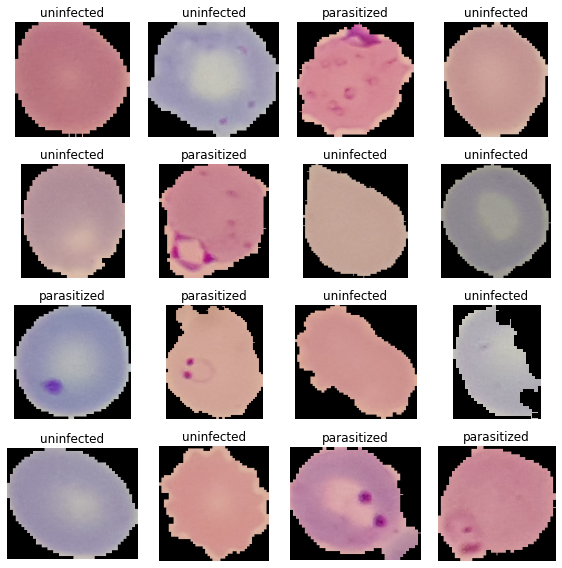

In [13]:
fig = plt.figure(figsize=(8, 8))  # Set the desired figure size

for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
  
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')
plt.tight_layout()          # Adjust subplots to avoid overlapping

In [14]:
print(dataset_info.features['label'].int2str(0))
print(dataset_info.features['label'].int2str(1))

parasitized
uninfected


## Data Preprocessing

### Data Augmentation

In [15]:
### tf.keras.layer resizing and rescaling
IM_SIZE = CONFIGURATION['IM_SIZE']
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),                               
])

@tf.function
def resize_rescale_single_layer(image, label):
  return (resize_rescale_layers(image)), label

In [16]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',)
                                  
])
@tf.function
def augment_layer_single_image(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [17]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [18]:
original_image, label = next(iter(train_dataset))

In [19]:
original_image.shape

TensorShape([145, 148, 3])

In [20]:
# Assuming you have a single image stored in the 'image' variable

# Reshape the image to add a batch dimension
image = tf.expand_dims(original_image, axis=0)

# Apply the resize_rescale_layers on the image
preprocessed_image = resize_rescale_layers(image)

# Remove the batch dimension and retrieve the preprocessed image
preprocessed_original_image = tf.squeeze(preprocessed_image, axis=0)

In [21]:
preprocessed_original_image.shape

TensorShape([224, 224, 3])

In [ ]:
augmented_image = augment_layers(preprocessed_original_image, training = True)

In [ ]:
augmented_image.shape

In [ ]:
visualize(preprocessed_original_image, augmented_image)

### Data Loading

In [ ]:
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']

In [ ]:
for image,label in train_dataset.take(1):
  print(image, label)

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset

In [ ]:
train_dataset

In [ ]:
fig = plt.figure(figsize=(8, 8))

num_images = 16  # Set the desired number of images to display

for i, (image_batch, label_batch) in enumerate(train_dataset.take(1)):
    for j in range(16):
        ax = plt.subplot(4, 4, j + 1)
        
        image = image_batch[j]
        plt.imshow(image)
        plt.title(dataset_info.features['label'].int2str(label_batch[j]))
        plt.axis('off')

plt.tight_layout()



### Repeating the dataset (x5)

# Model Creation and Training

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

In [ ]:
model_seq = tf.keras.Sequential([
    augment_layers,
    
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    
    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid', activation = 'relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Conv2D(filters = N_FILTERS*2, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation = 'relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),
    
    Conv2D(filters = N_FILTERS*2, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation = 'relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),
    
    Conv2D(filters = N_FILTERS*2, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation = 'relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE*2),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_initializer=initializers.HeNormal()),

    Dense(1, activation = "sigmoid"),

])


In [ ]:
model_seq.build((None, IM_SIZE, IM_SIZE, 3))  # Build the model with a specific input shape
model_seq.summary()

# Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))
    
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

### CSVLogger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### EarlyStopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=4, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### LearningRateScheduler

In [ ]:
def scheduler(epoch, lr):

  if epoch <= 10:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

### ReduceLearningRateOnPlateau

In [ ]:
# this is another type of call back
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

## Training

In [ ]:
metrics = [ BinaryAccuracy(name='accuracy')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [ ]:
model_seq.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),       
      metrics = metrics)

In [ ]:
history = model_seq.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[es_callback, csv_callback, plateau_callback]
    )

## Hyperparameter Tuning

In [ ]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),
    
    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

fixed range of values is very large


In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,
              
          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

## Custom Training Loop

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)
      
    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
      
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)
      
    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

In [ ]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

In [ ]:
# image = cv2.imread('cell.jpg')
# print(image.shape)
# image = tf.expand_dims(image, axis = 0)
# print(image.shape)

# lenet_model.predict(image)

## Visualizations

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=logs\140623-105112\metrics

In [ ]:
print(history.history.keys())

In [ ]:
#import matplotlib.pyplot as plt

# Assuming you have a training history object named 'history'
lr_values = history.history['lr']  # Extract the learning rate values from the history

# Create a list of epochs corresponding to the learning rate values
epochs = range(1, len(lr_values) + 1)

# Plotting the learning rate
plt.plot(epochs, lr_values)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation and Testing**

In [ ]:
test_dataset

In [ ]:
test_dataset1 = (
    test_dataset
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
test_dataset1

In [ ]:
model_seq.evaluate(test_dataset1)

## Visualizing Confusion Matrix

In [ ]:
true_labels = []
predicted_labels = []

for image, label in test_dataset:
    true_labels.append(label.numpy())
    # Make predictions using your model
    # model.predict(image) -> predicted_label
    input_img = resize_rescale_layers(image)
    input_image = tf.expand_dims(input_img, axis=0)
    prediction = model_seq.predict(input_image)
    
    predicted_label = 0 if prediction < 0.5 else 1

    predicted_labels.append(predicted_label)


In [ ]:
len(predicted_labels)

In [ ]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# ==============================================================

# Make predictions on imported image

In [ ]:
# Make predictions
sample_image_path = 'image.png'  # Path to the sample image you want to predict



In [ ]:
sample_image = tf.keras.preprocessing.image.load_img(
    sample_image_path
)

In [ ]:
img = np.array(sample_image)

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
img = resize_rescale_layers(img)

In [ ]:
img = tf.expand_dims(img, axis=0)

In [ ]:
print(img.shape)

In [ ]:
model_seq.predict(img)

In [ ]:
prediction = model_seq.predict(img)
predicted_class = 'parasitized' if prediction < 0.5 else 'uninfected'

print('Prediction:', predicted_class)

In [ ]:
#tp: 1267.0000 - fp: 99.0000 - tn: 1298.0000 - fn: 93.0000

## ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(true_labels, predicted_labels)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
  
plt.show()

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model_seq.predict(test_dataset1)[0][0])

In [ ]:
fig = plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(test_dataset1.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title('Actual : Predicted -> ' + str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model_seq.predict(image)[0])))
  
  plt.axis('off')

plt.tight_layout()

# Visualizing intermidiate layer

In [ ]:
def is_conv(layer_name):
    if 'conv' in layer_name:
        return True
    else:
        return False

In [ ]:
feature_maps = [layer.output for layer in model_seq.layers[2:-1] if is_conv(layer.name)]

In [ ]:
feature_maps

In [ ]:
feature_map_model = Model(
    inputs = model_seq.input,
    outputs = feature_maps
)

In [ ]:
feature_map_model.summary()

In [ ]:
sample_image_path = 'image.png'
sample_image = tf.keras.preprocessing.image.load_img(
    sample_image_path
)

img = np.array(sample_image)

img = resize_rescale_layers(img)
img = tf.expand_dims(img, axis=0)


In [ ]:
f_maps = feature_map_model.predict(img)

In [ ]:
for i in range(len(f_maps)):
    print(f_maps[i].shape)

In [ ]:
for i in range(len(f_maps)):
    plt.figure(figsize = (224,224))
    f_size = f_maps[i].shape[1]
    n_channels = f_maps[i].shape[3]
    joint_maps = np.ones((f_size, f_size*n_channels ))

    axs = plt.subplot(len(f_maps), 1, i+1)
  
    for j in range(n_channels):
        joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

    plt.imshow(joint_maps[:,0:512])
    plt.axis("off")

# Loading and Saving

In [ ]:
model_seq.save("model_final.hdf5")

In [ ]:
model = tf.keras.models.load_model("model_final.hdf5")
model.summary()